In [1]:
import collections
import matplotlib.pyplot as plt
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc
from plot_utils.common_plots import rank, average_plot
from plot_utils.common_tables import collect_data_for_final_table, do_wilcoxon_test
from plot_utils.common_loading import load_from_openml

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_test_benchmark, get_normalization_constants

In [2]:
username = getpass.getuser()
dir_ = {
    'eggenspk': "/home/eggenspk/Work/data/ASKL_20/",
    'feurerm': "/home/feurerm/projects/2021_posh/",
}[username]

valid_pretty = {
    #1: {
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    #(None, "1MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    #},
    10: {
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    (None, "10MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    },
    60: {
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    (None, "60MIN/ASKL_automldata_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    },
}

task_ids = automl_test_benchmark
n_seeds = 3
task_ids = openml_automl_benchmark
n_seeds = 10

res_dc = {}
miss = 0
for horizon in list(valid_pretty.keys()):
    res_dc[horizon] = {}
    for tid in task_ids:
        res_dc[horizon][tid] = {}
        for mode in list(valid_pretty[horizon].keys()):
            if type(mode) == tuple:
                auto, model_name = mode
            else:
                model_name = mode
                auto = None
            res_dc[horizon][tid][mode] = []
            for seed in range(n_seeds):
                fl_tmpl = dir_ + "/" + model_name + "_%d_%d_0_0/result.json" % (tid, seed)
                fl = glob.glob(fl_tmpl)               
                if len(fl) == 0:
                    miss += 1
                    print(fl_tmpl)
                    continue
                fl = fl[0]
                with open(fl, "r") as fh:
                    line = json.load(fh)
                    loss = line["0"]["trajectory"]
                    loss = [(l[0], l[1]) for l in loss]
                    loss = dict(loss)
                    res_dc[horizon][tid][mode].append(loss)
print("Missing %d entries" % miss)

Missing 0 entries


In [3]:
# Load some stuff from disc and openml - takes some time
tasks, task_ids_sorted_by_num_features = load_from_openml(task_ids)
min_diff_dc, _, _, _, _ = get_normalization_constants(
    results_dir=os.path.join(dir_, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble"),
    task_ids=task_ids,
    load=False,
    n_seeds=n_seeds,
)
tasks

Loaded tasks from openml
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168794 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168797 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find a ru

,tid,ttid,did,name,task_type,status,estimation_procedure,evaluation_measures,source_data,target_feature,...,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,cost_matrix
189871,189871,TaskType.SUPERVISED_CLASSIFICATION,41163,dilbert,Supervised Classification,active,33% Holdout set,NaN,41163,class,...,5.0,1913.0,5.0,2001.0,10000.0,0.0,0.0,2000.0,1.0,NaN
189872,189872,TaskType.SUPERVISED_CLASSIFICATION,41164,fabert,Supervised Classification,active,33% Holdout set,NaN,41164,class,...,7.0,502.0,7.0,801.0,8237.0,0.0,0.0,800.0,1.0,NaN
189873,189873,TaskType.SUPERVISED_CLASSIFICATION,41167,dionis,Supervised Classification,active,33% Holdout set,NaN,41167,class,...,355.0,878.0,355.0,61.0,416188.0,0.0,0.0,60.0,1.0,NaN
168794,168794,TaskType.SUPERVISED_CLASSIFICATION,41165,robert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41165,class,...,10.0,958.0,10.0,7201.0,10000.0,0.0,0.0,7200.0,1.0,NaN
168792,168792,TaskType.SUPERVISED_CLASSIFICATION,41168,jannis,Supervised Classification,active,33% Holdout set,predictive_accuracy,41168,class,...,4.0,1687.0,4.0,55.0,83733.0,0.0,0.0,54.0,1.0,NaN
168793,168793,TaskType.SUPERVISED_CLASSIFICATION,41166,volkert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41166,class,...,10.0,1361.0,10.0,181.0,58310.0,0.0,0.0,180.0,1.0,NaN
75105,75105,TaskType.SUPERVISED_CLASSIFICATION,1111,KDDCup09_appetency,Supervised Classification,active,33% Holdout set,predictive_accuracy,1111,APPETENCY,...,15415.0,890.0,2.0,231.0,50000.0,50000.0,8024152.0,192.0,39.0,NaN
189906,189906,TaskType.SUPERVISED_CLASSIFICATION,40984,segment,Supervised Classification,active,33% Holdout set,NaN,40984,class,...,7.0,330.0,7.0,20.0,2310.0,0.0,0.0,19.0,1.0,NaN
189909,189909,TaskType.SUPERVISED_CLASSIFICATION,41027,jungle_chess_2pcs_raw_endgame_complete,Supervised Classification,active,33% Holdout set,NaN,41027,class,...,3.0,4335.0,3.0,7.0,44819.0,0.0,0.0,6.0,1.0,NaN
189908,189908,TaskType.SUPERVISED_CLASSIFICATION,40996,Fashion-MNIST,Supervised Classification,active,33% Holdout set,NaN,40996,class,...,10.0,7000.0,10.0,785.0,70000.0,0.0,0.0,784.0,1.0,NaN


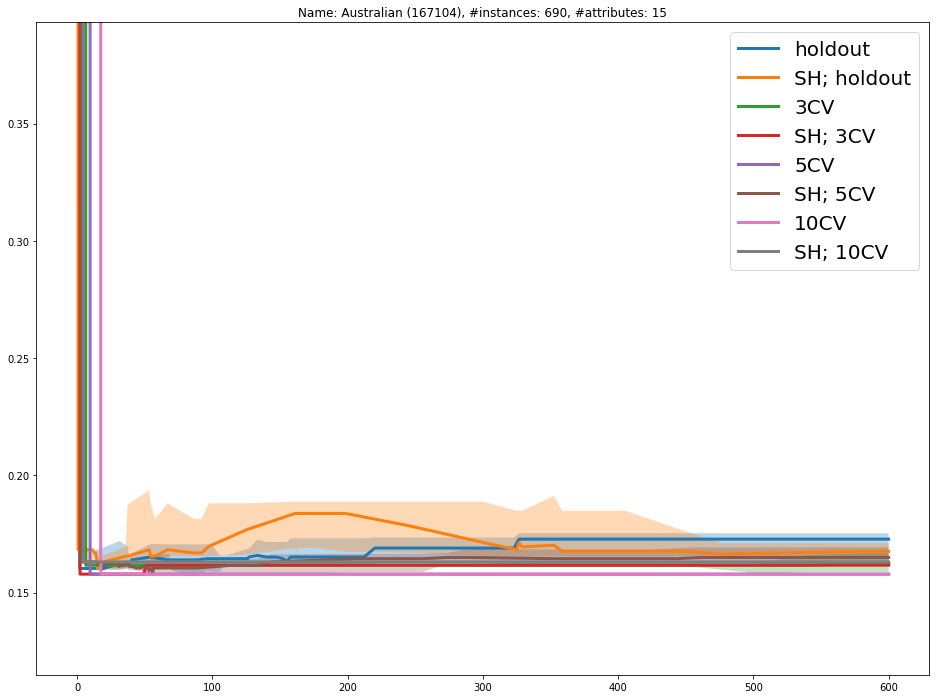

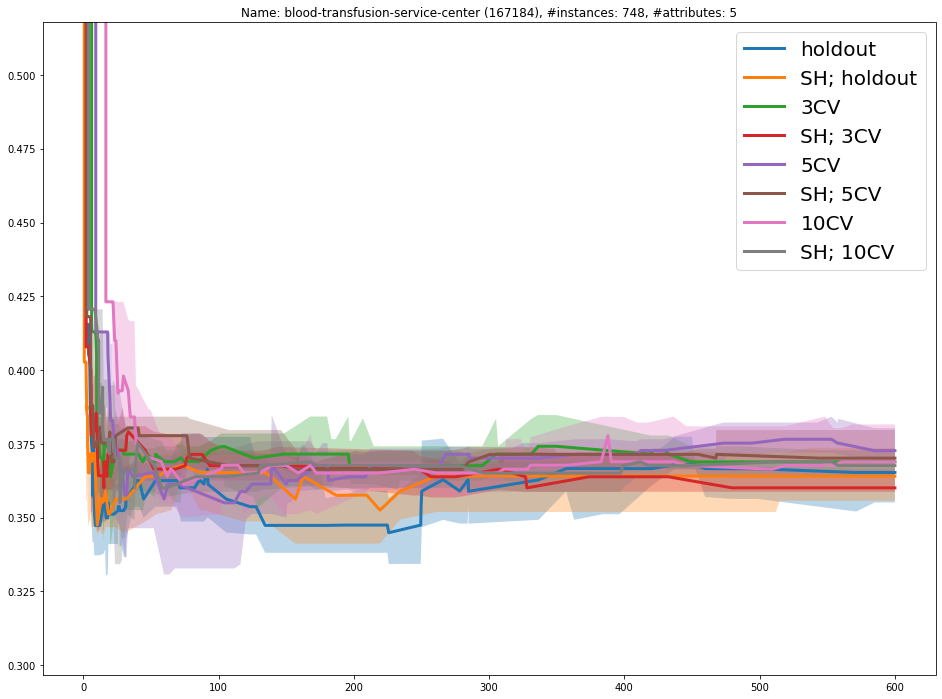

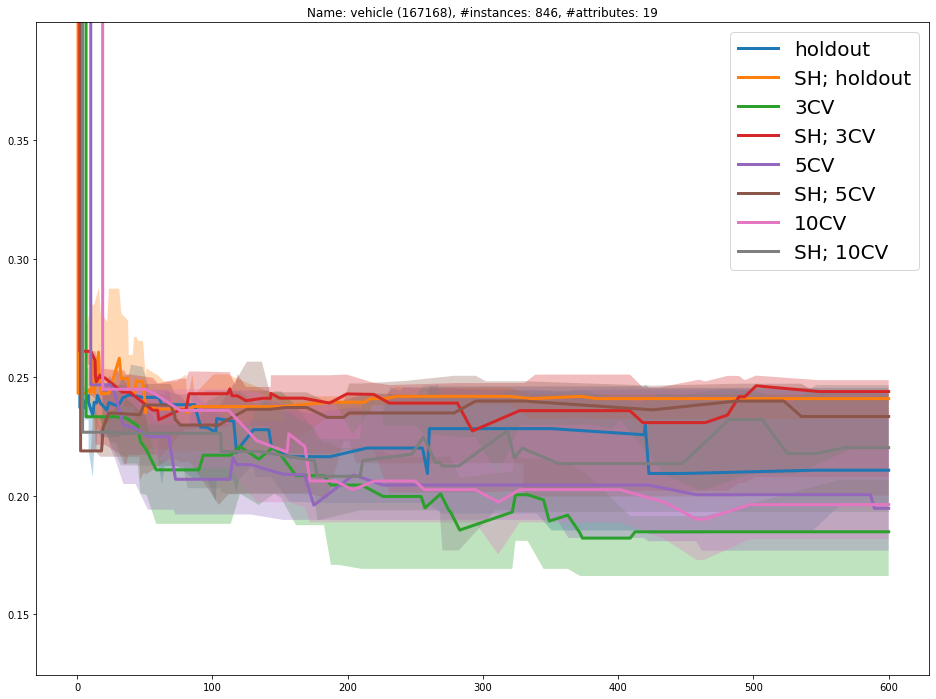

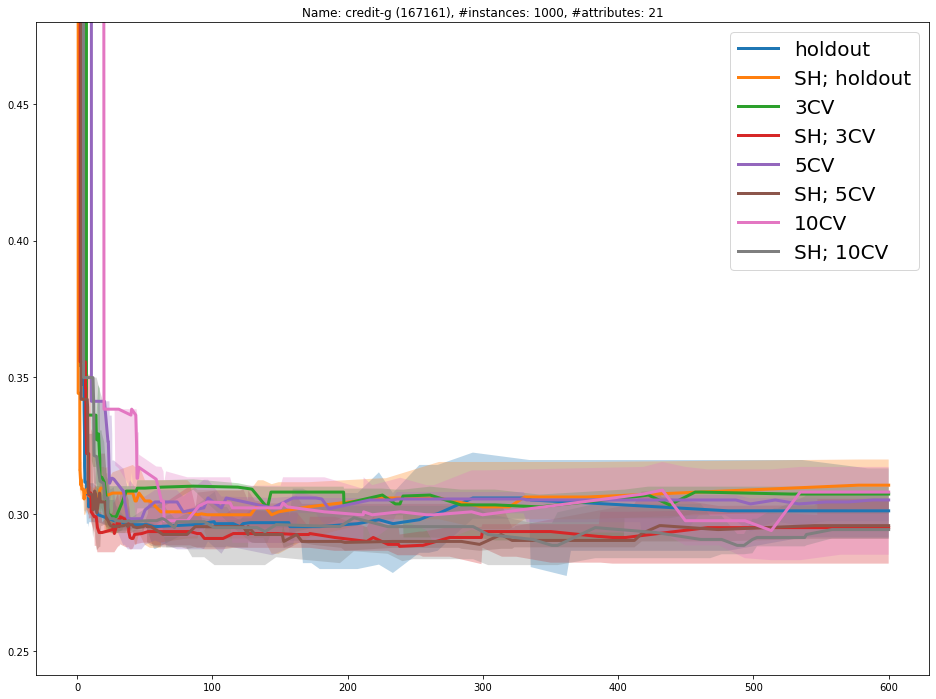

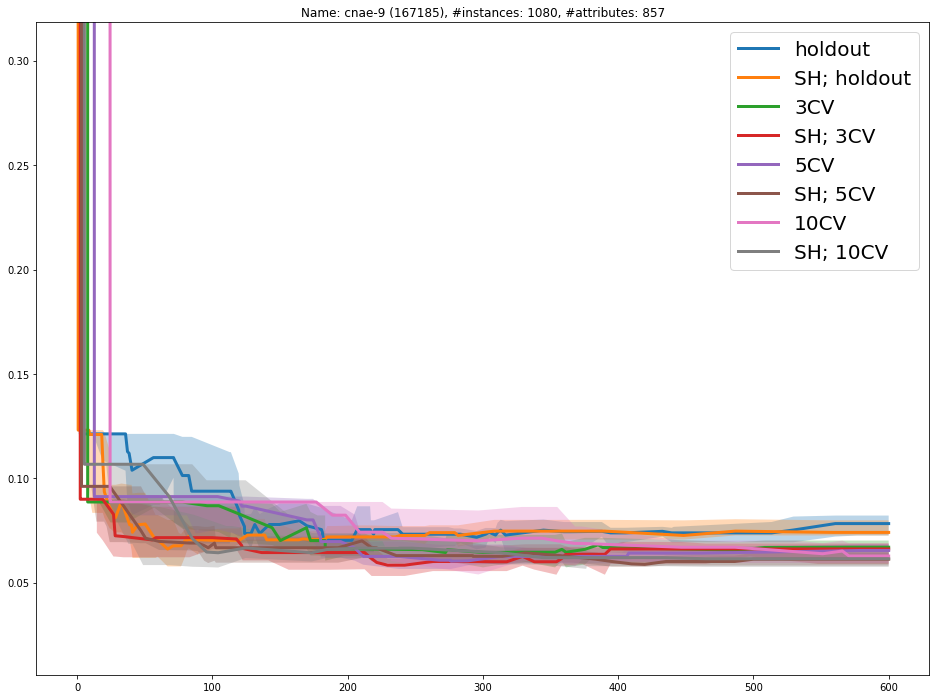

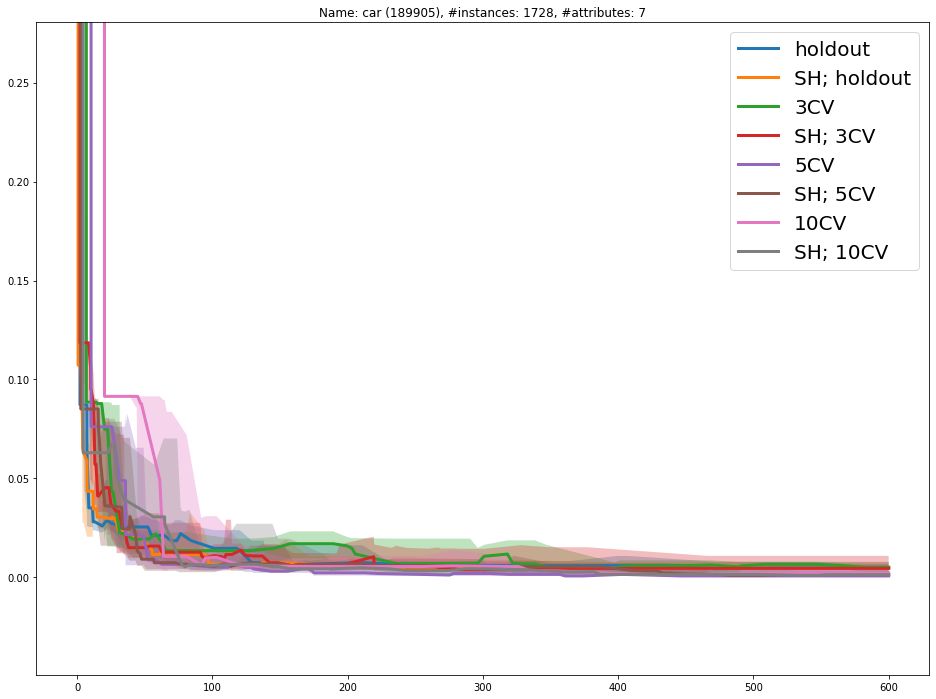

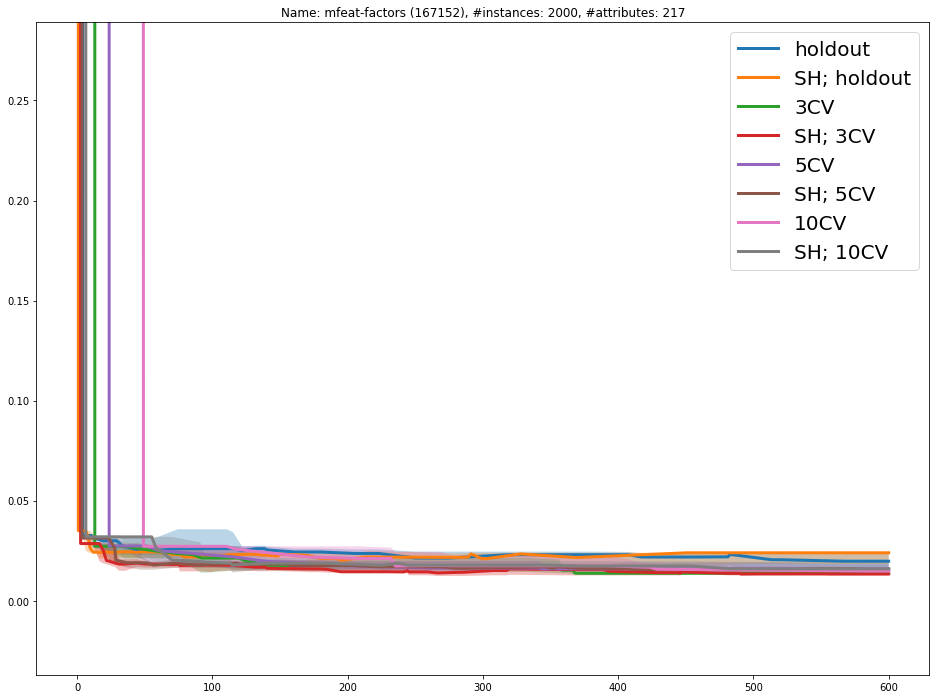

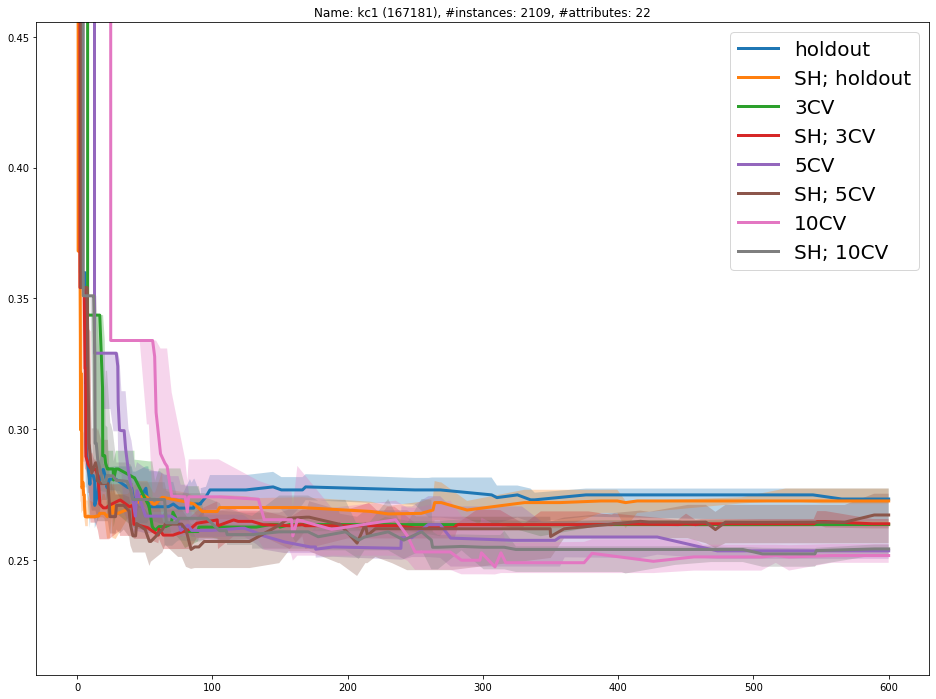

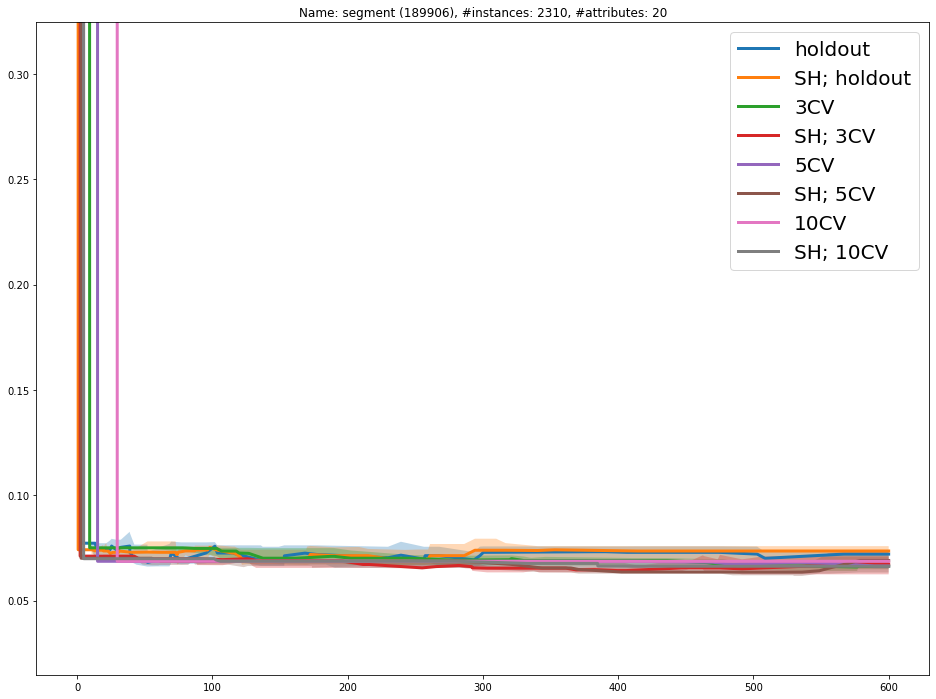

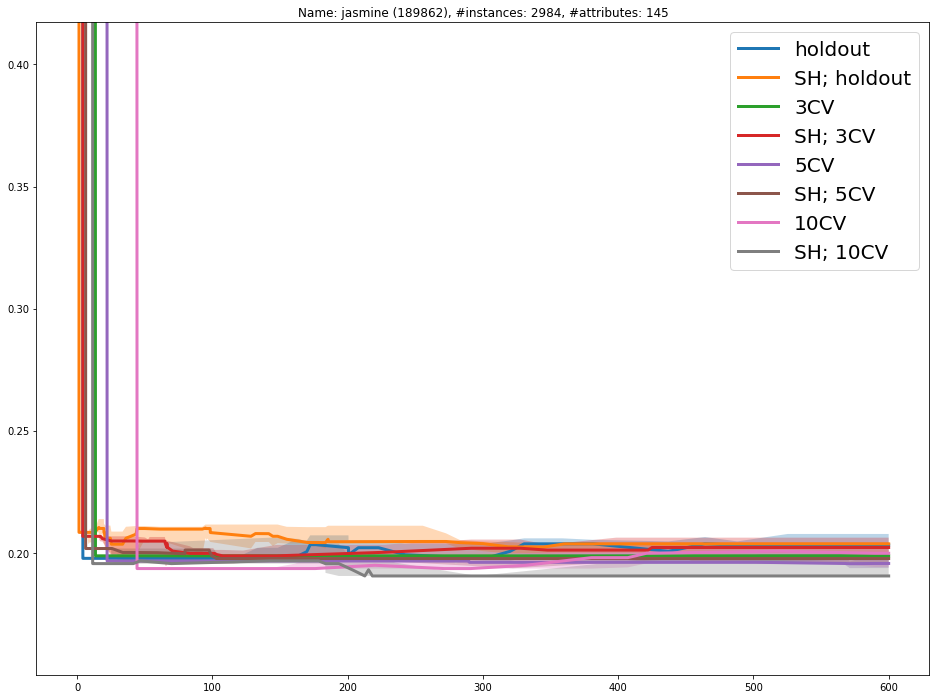

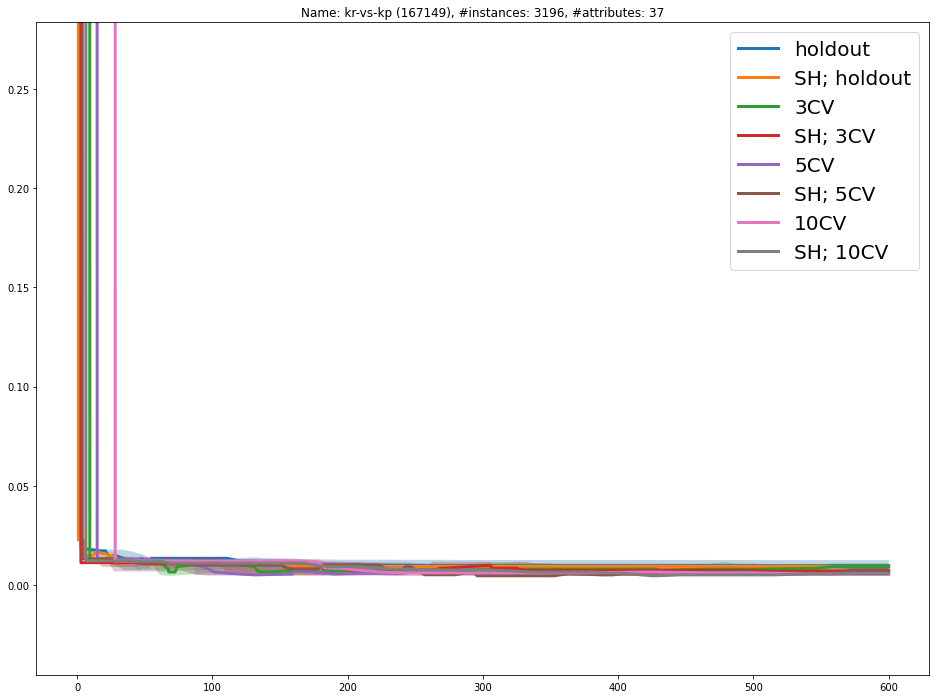

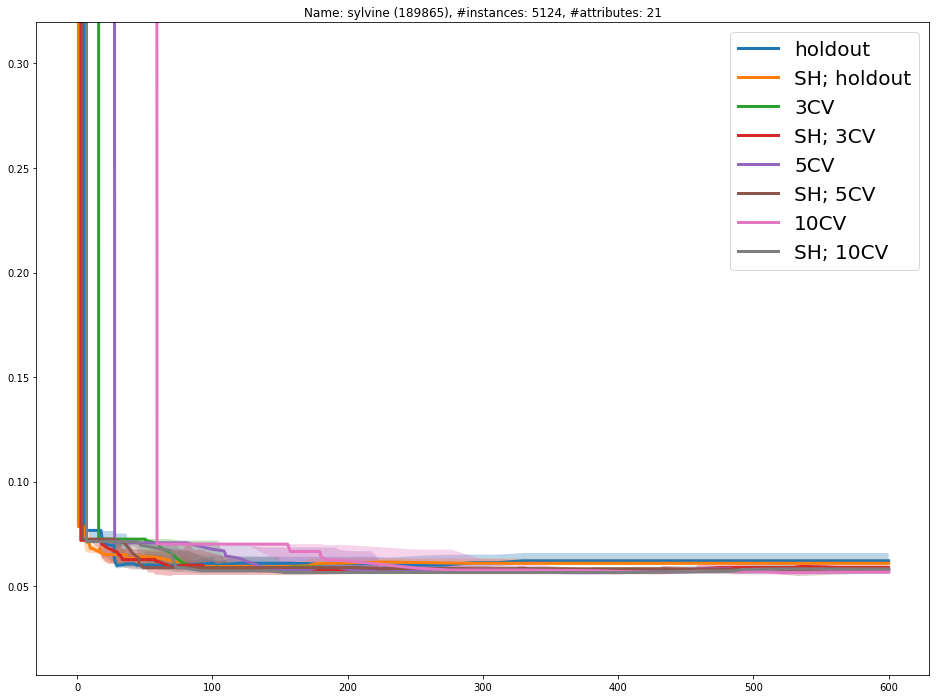

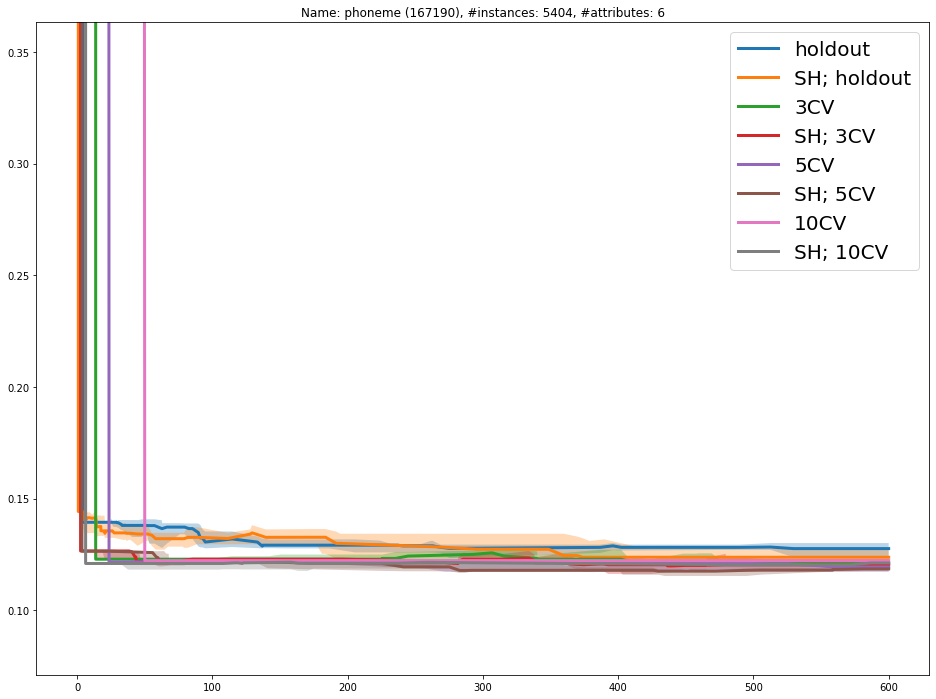

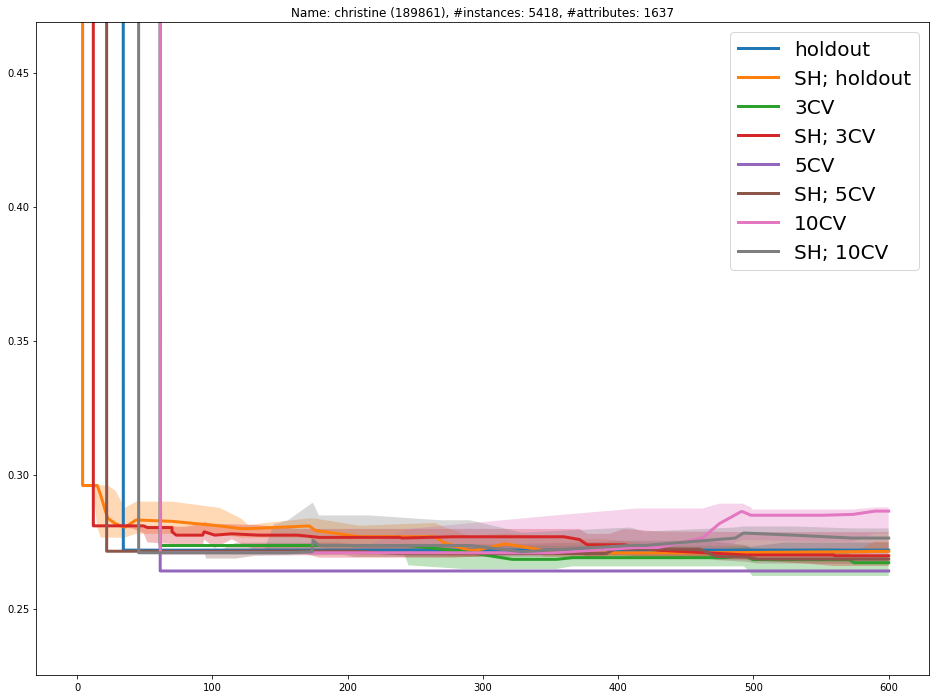

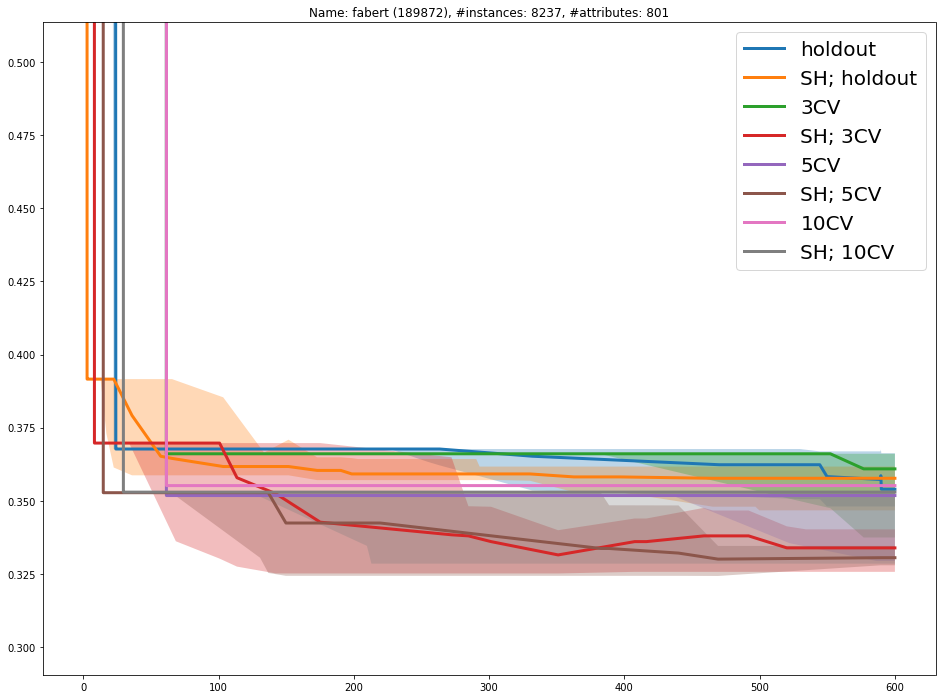

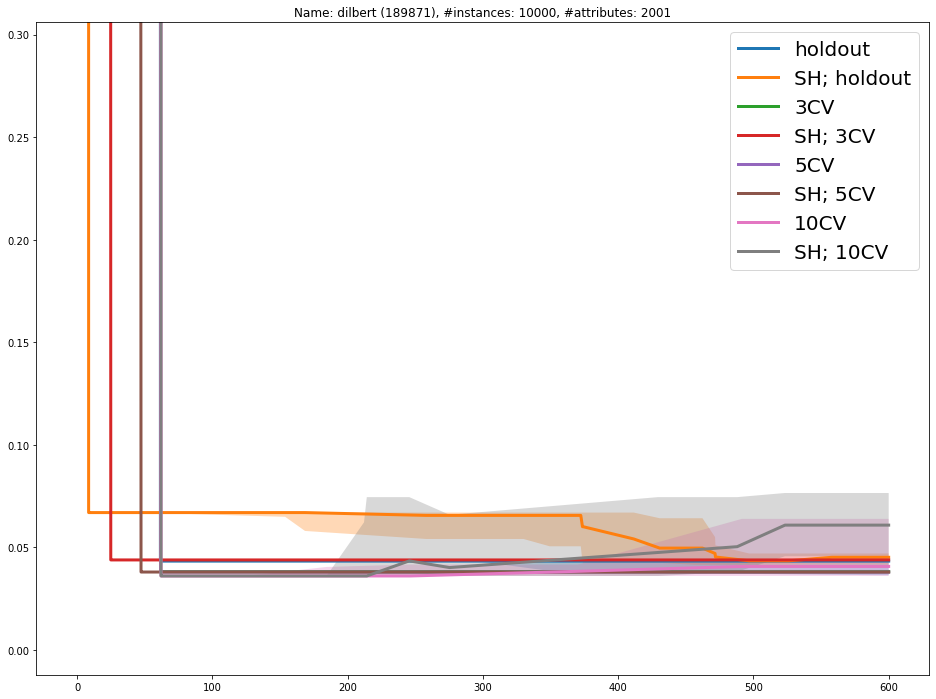

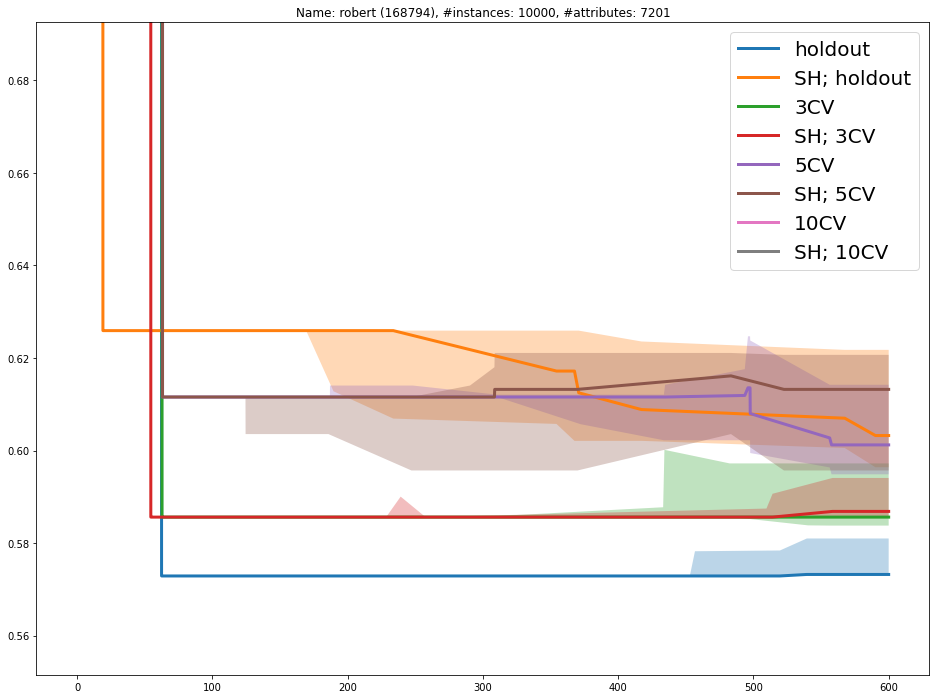

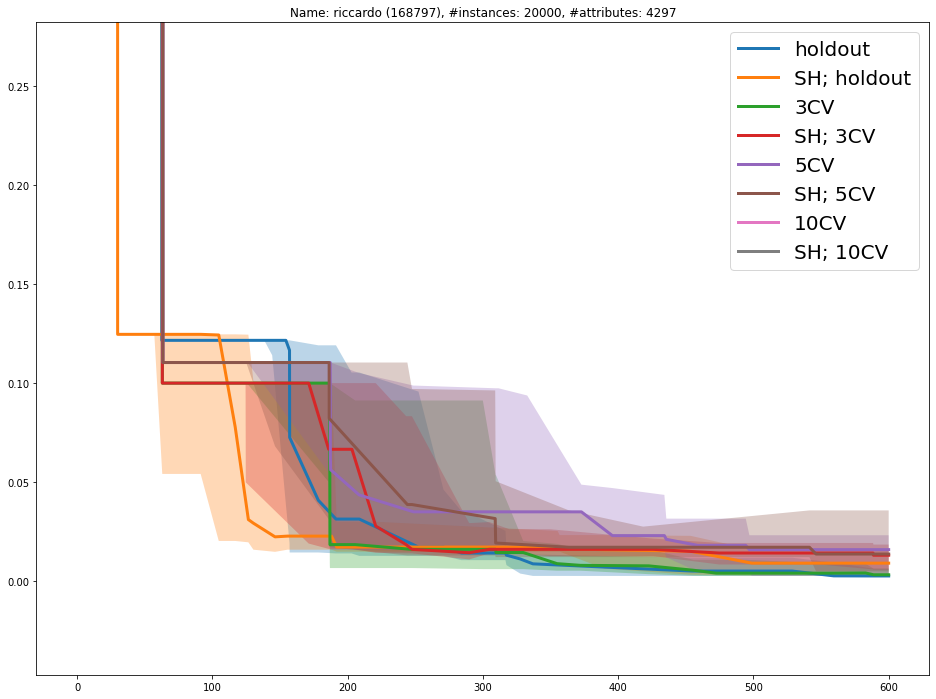

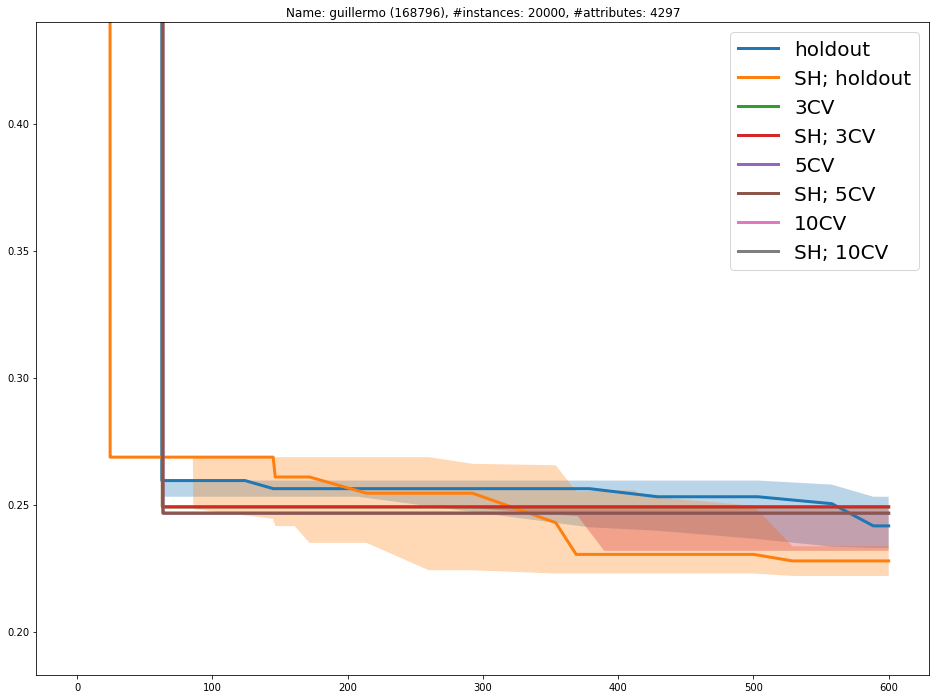

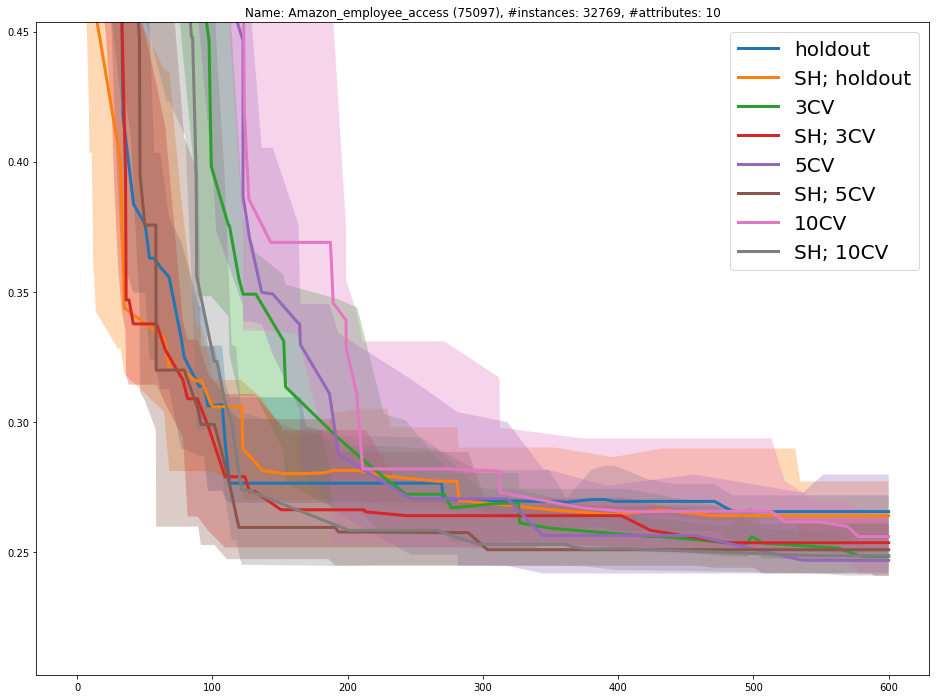

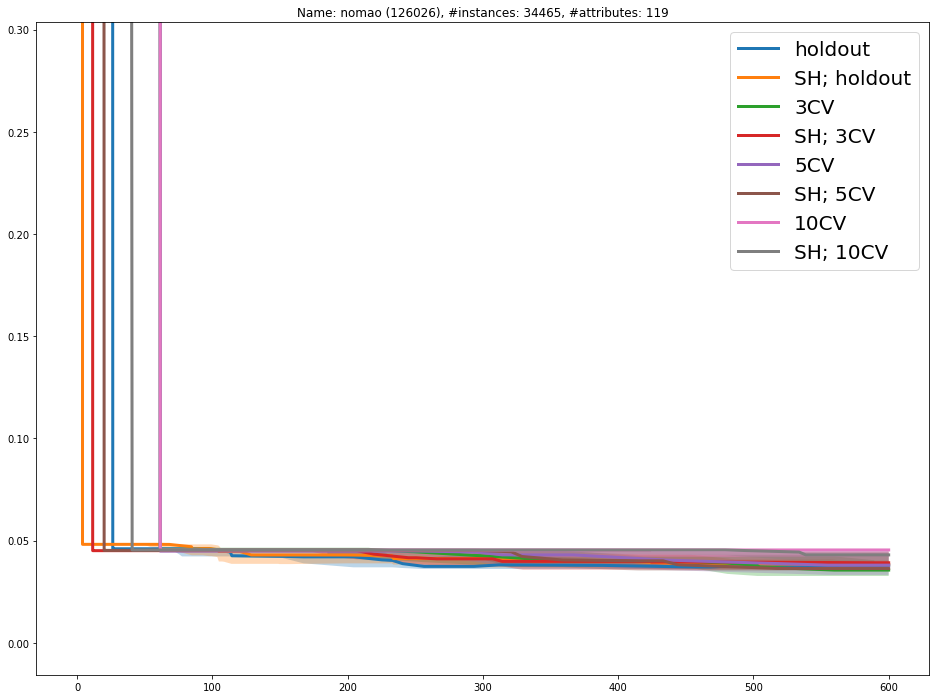

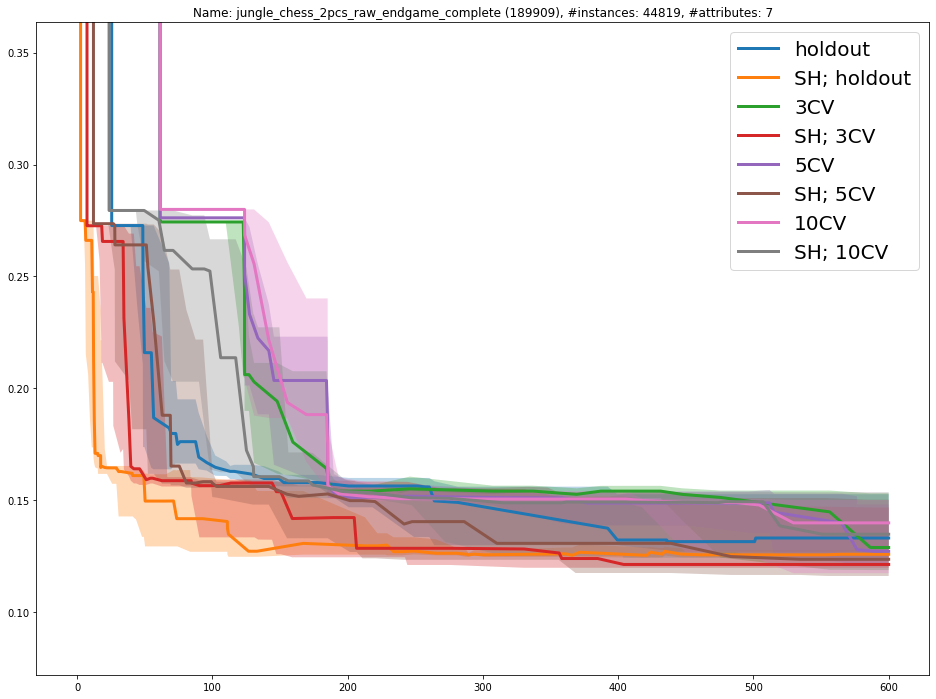

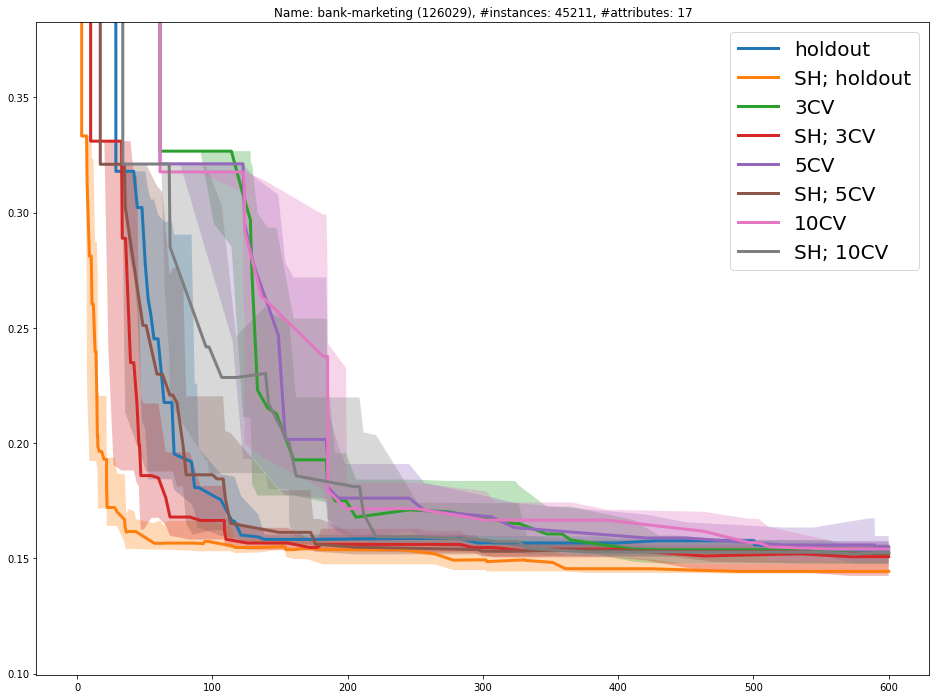

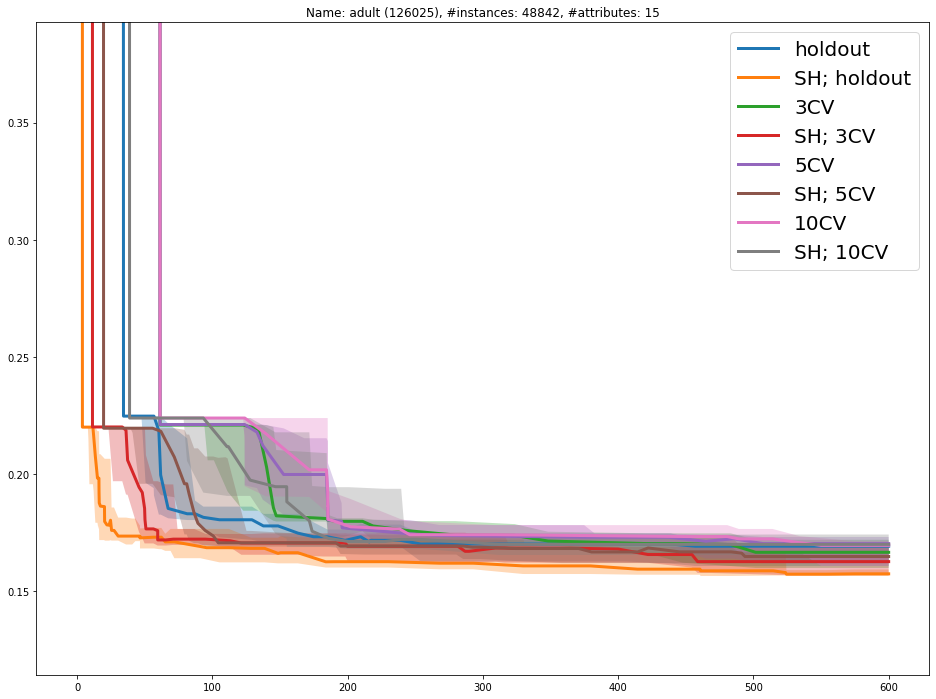

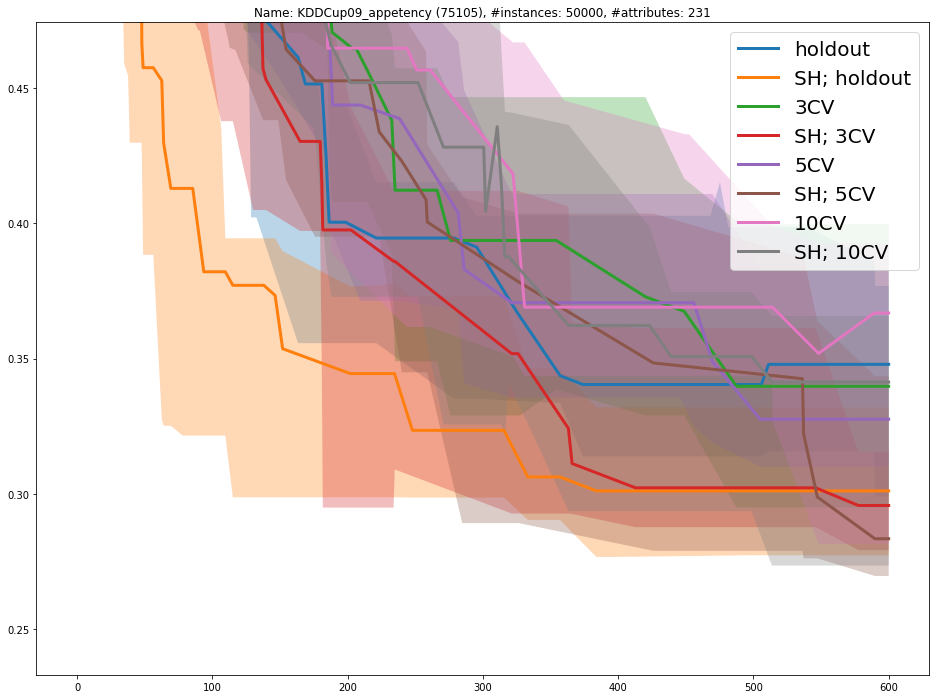

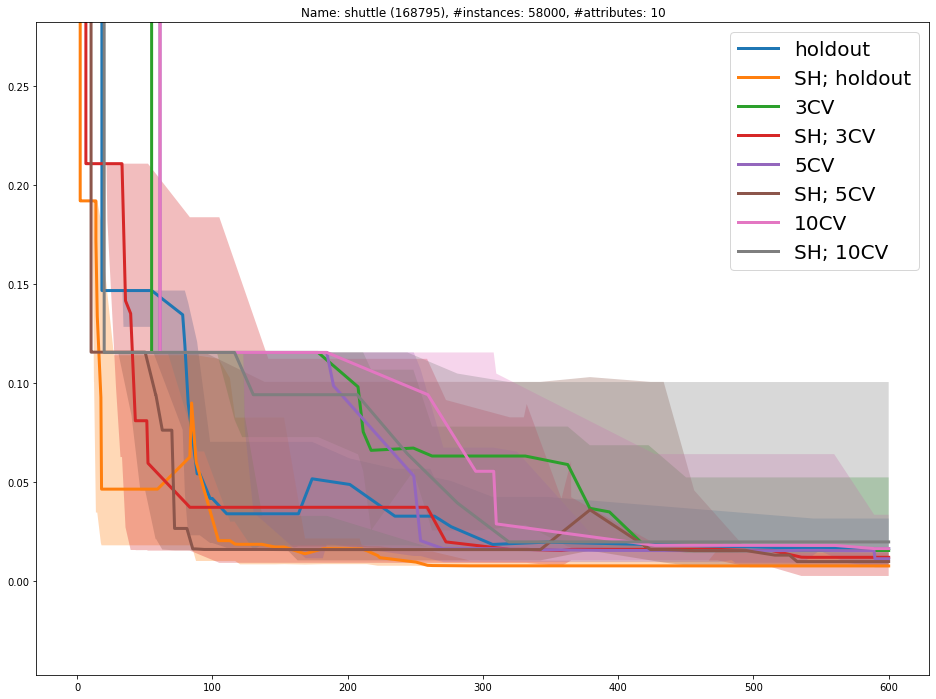

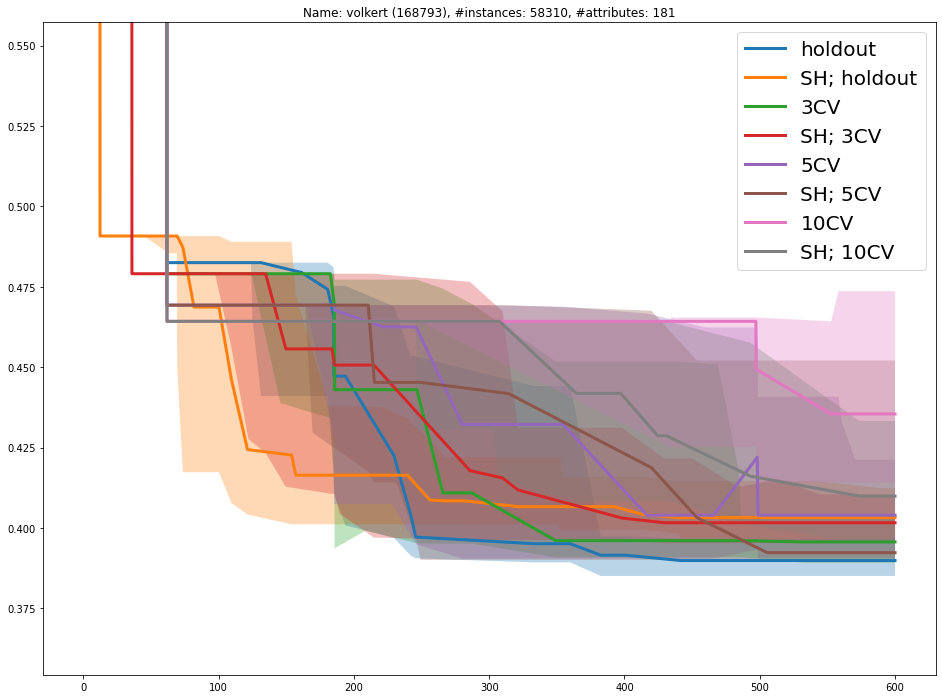

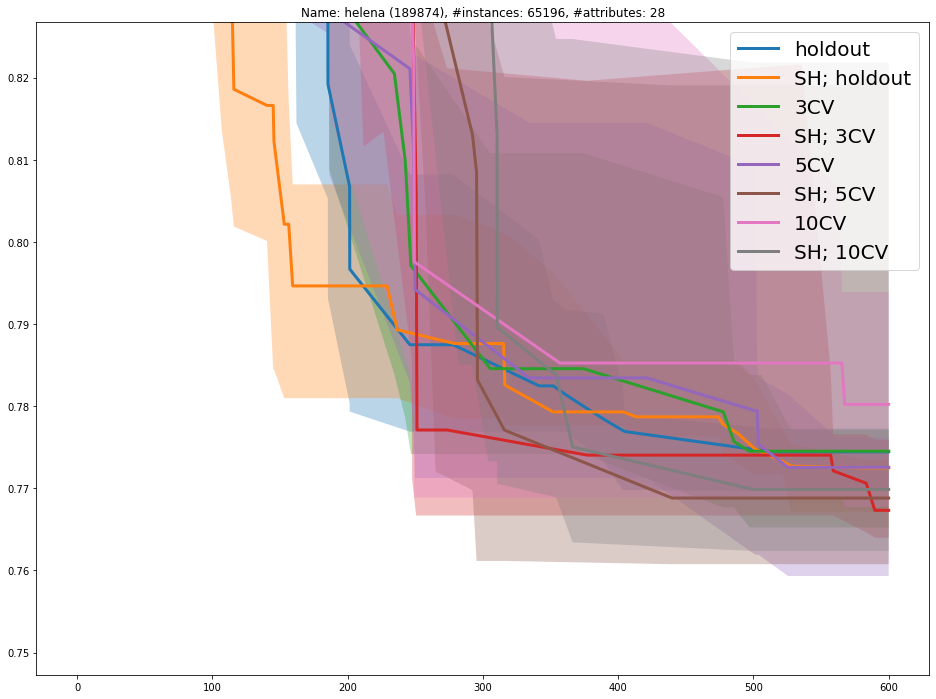

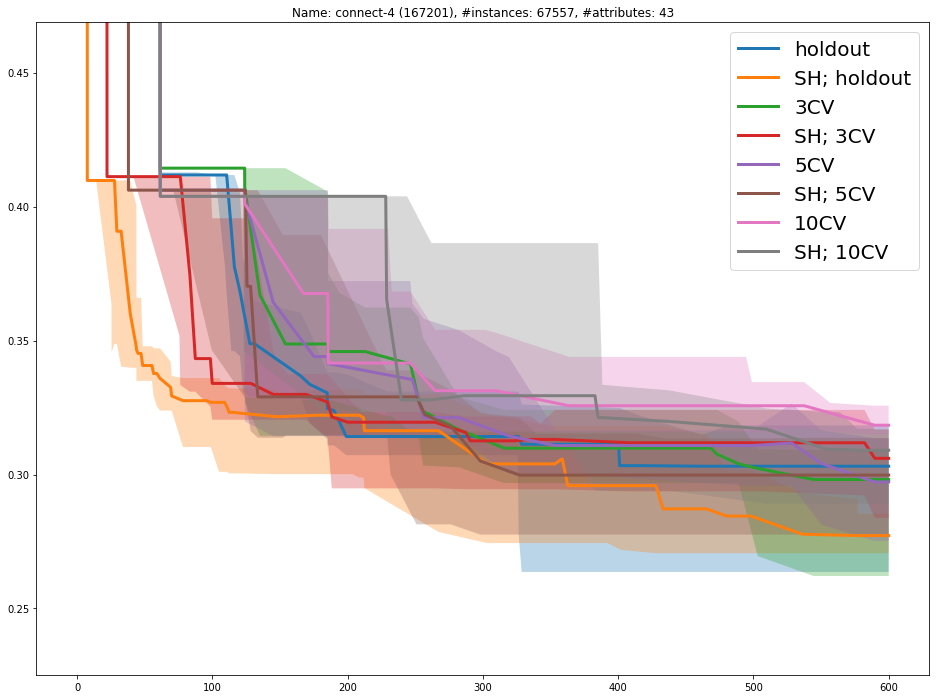

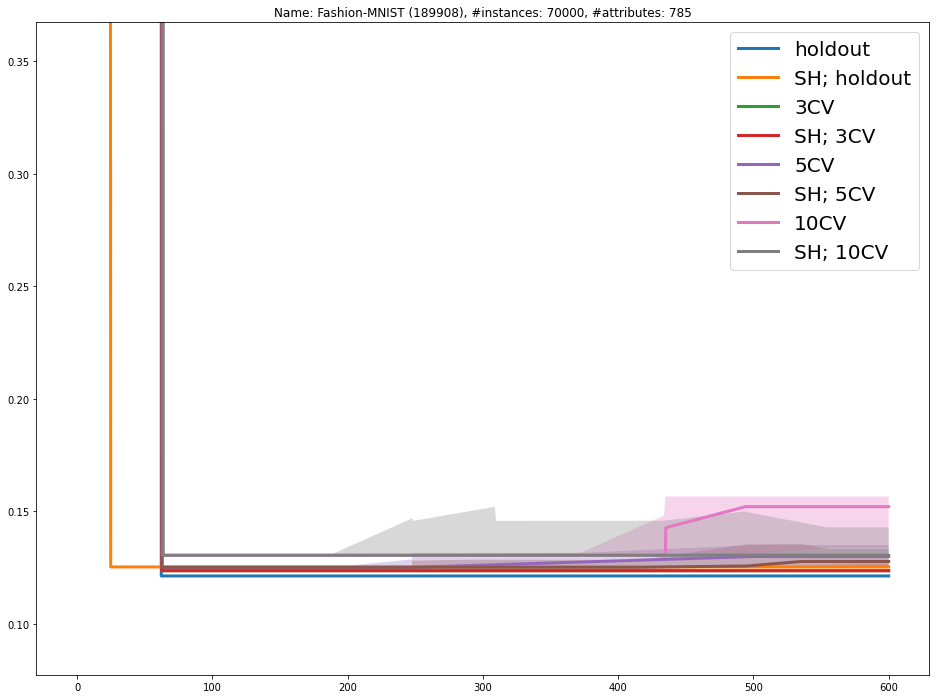

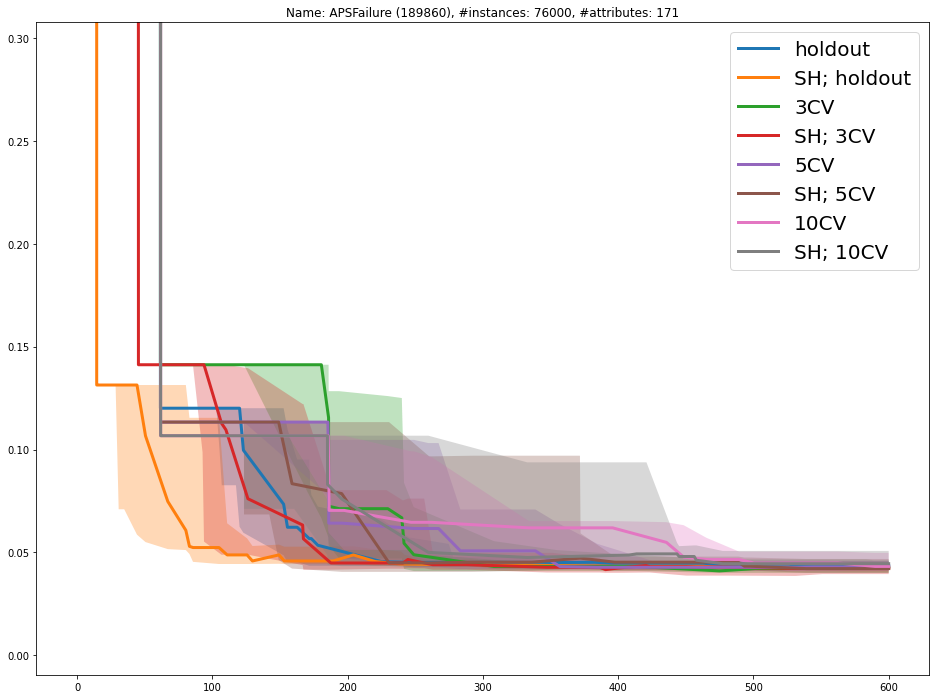

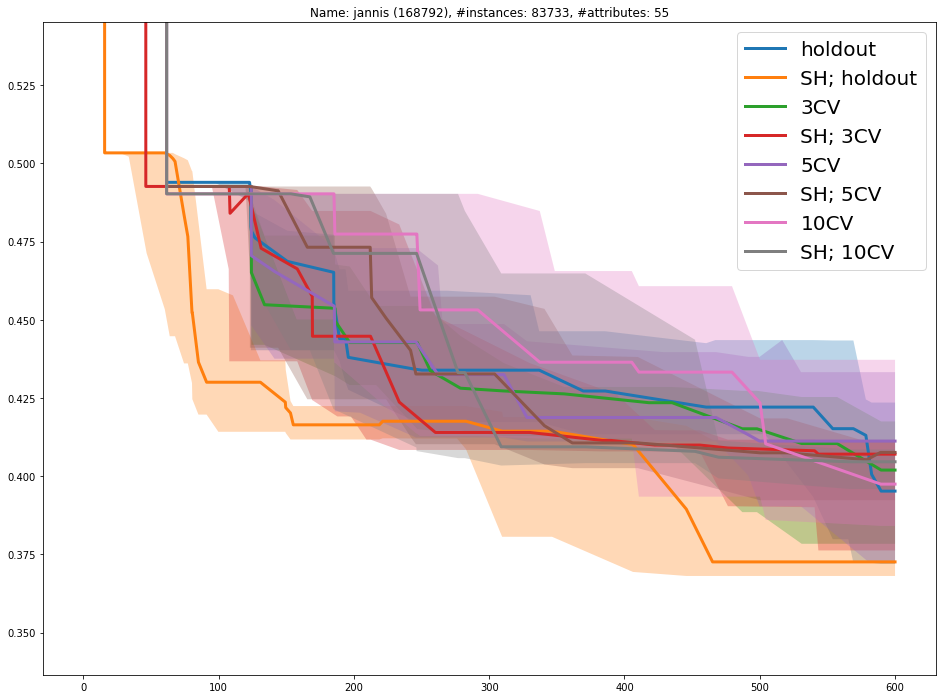

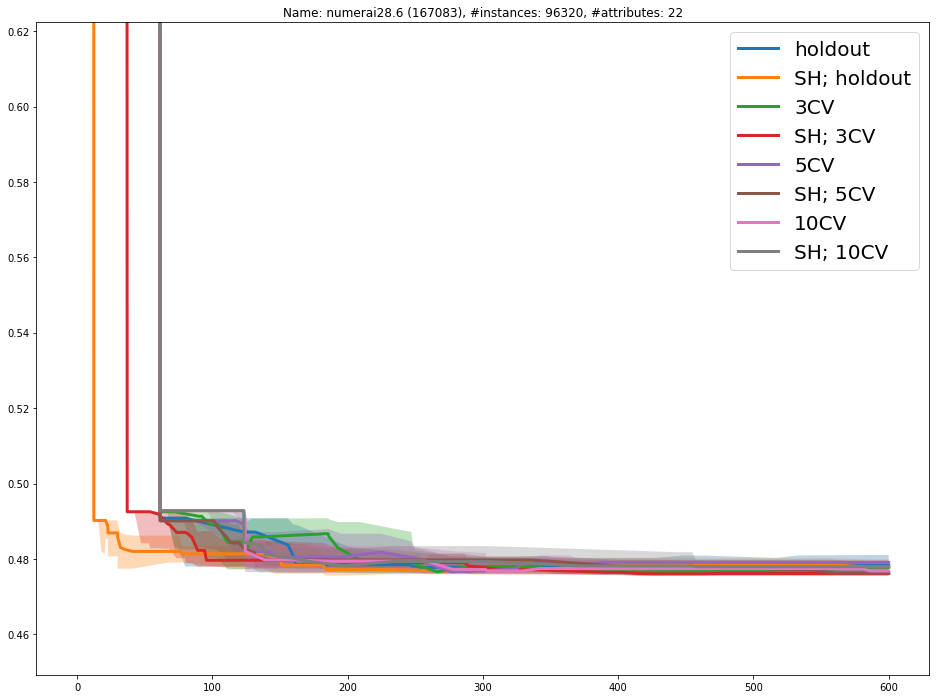

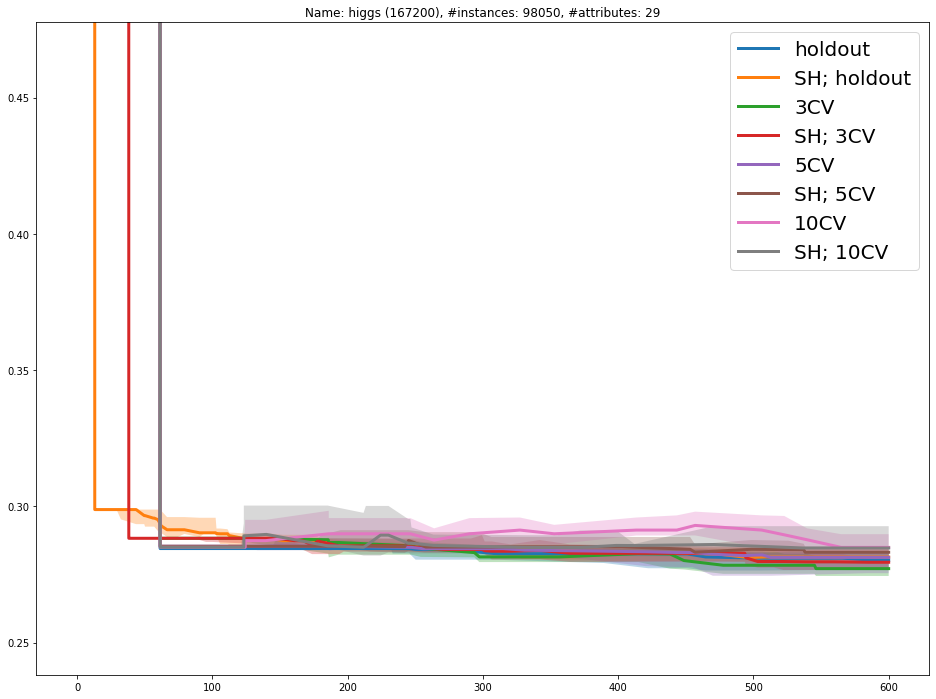

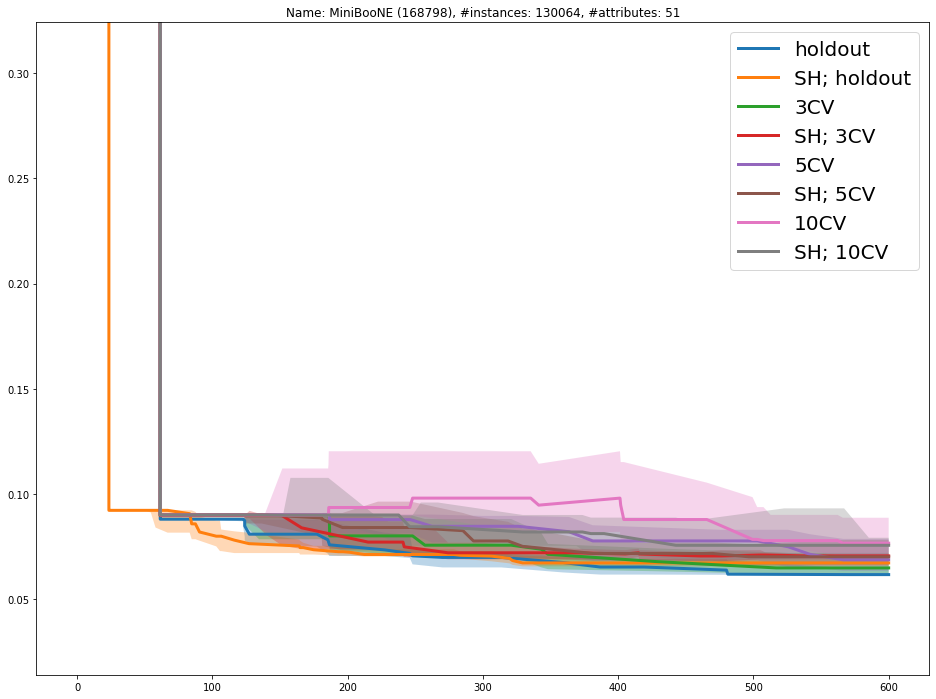

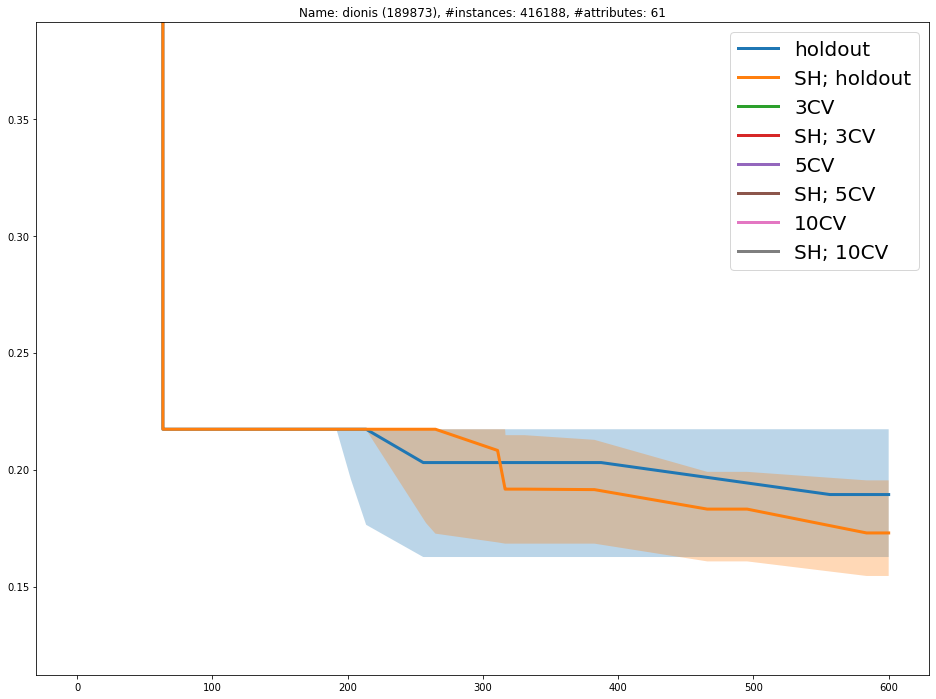

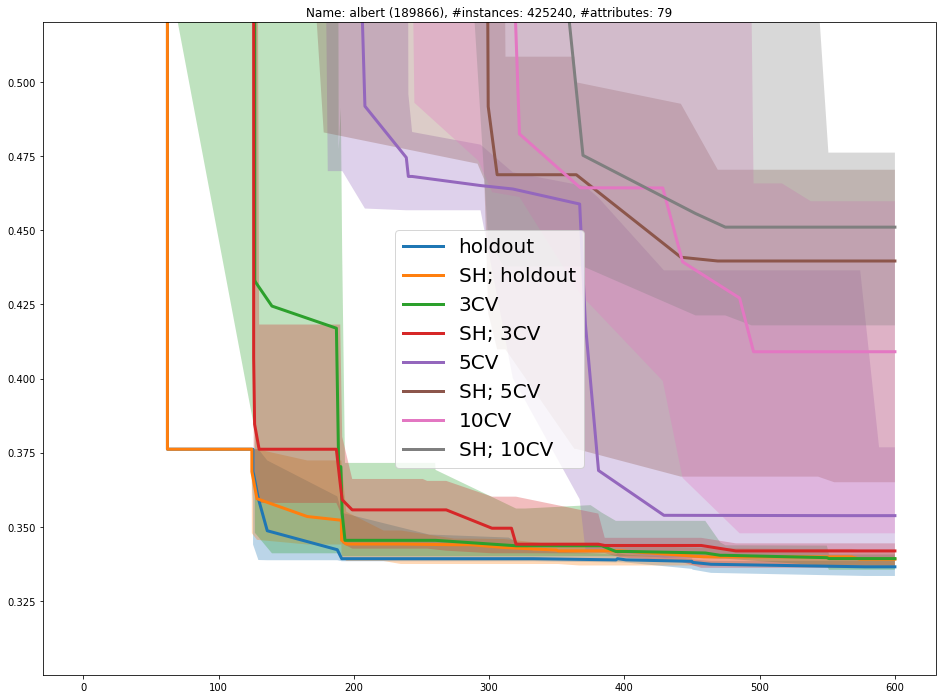

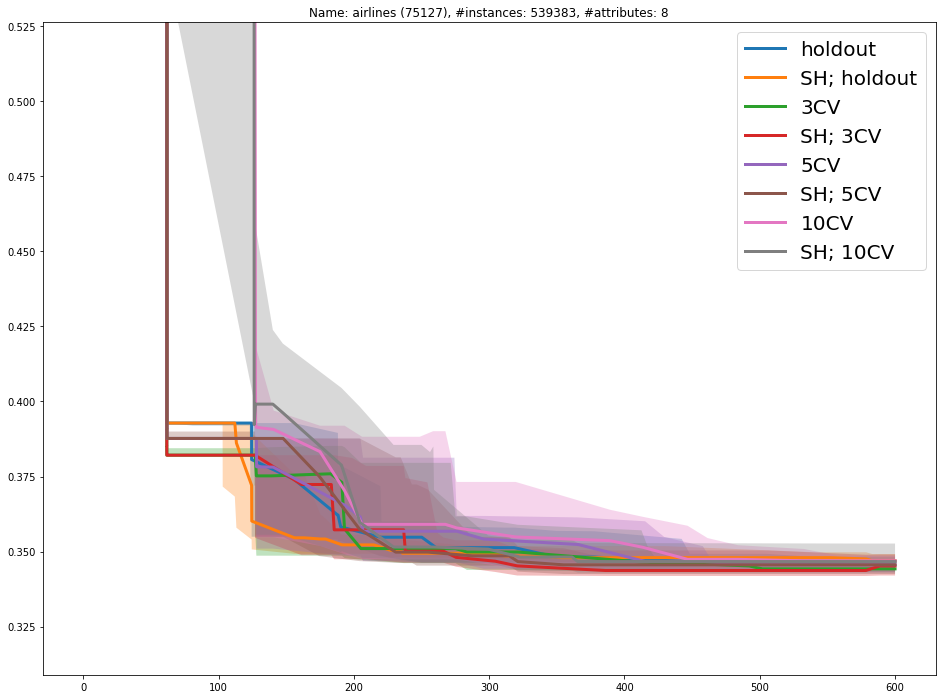

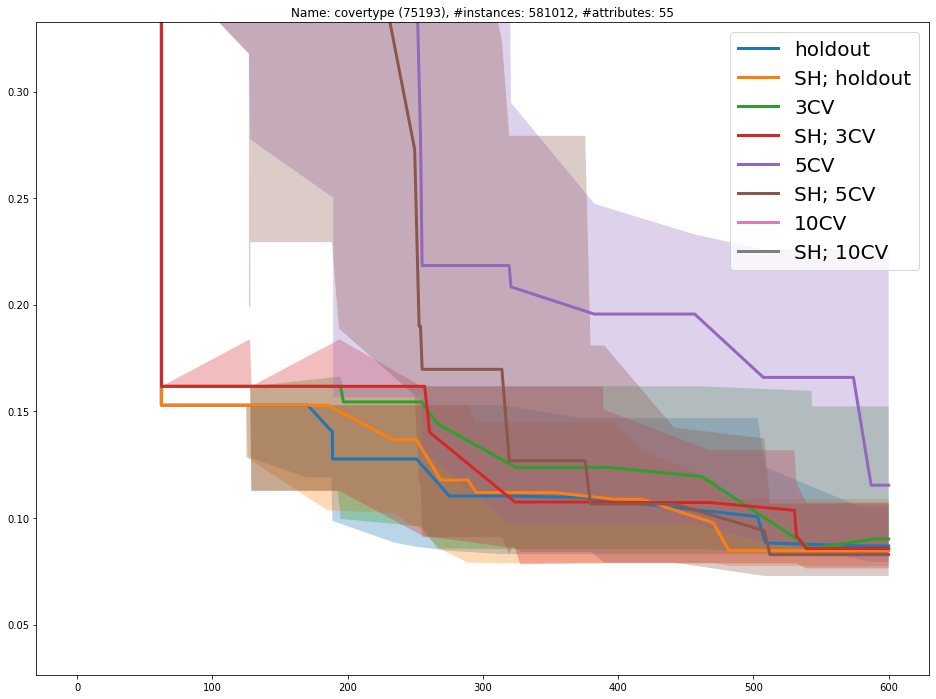

In [4]:
HORIZON = 10
for tid in task_ids_sorted_by_num_features:
    plt.figure(figsize=[16,12])
    colors = itertools.cycle(style_dc['colors'])
    for mode in list(valid_pretty[HORIZON].keys()):
        c = next(colors)
        tmp = pd.DataFrame(res_dc[HORIZON][tid][mode]).sort_index(axis=1).ffill(axis=1)
        med = tmp.median(axis=0)
        med.loc[HORIZON*60] = med.iloc[-1]
        low = tmp.quantile(0.25)
        low.loc[HORIZON*60] = low.iloc[-1]
        up = tmp.quantile(0.75, axis=0)
        up.loc[HORIZON*60] = up.iloc[-1]
        plt.plot(med.index, med.to_numpy(), label=valid_pretty[HORIZON][mode], linewidth=3)
        plt.fill_between(med.index, low, up, alpha=0.3)
    plt.title('Name: %s (%d), #instances: %d, #attributes: %d' % (
        tasks.loc[tid, 'name'], tid, tasks.loc[tid, 'NumberOfInstances'], tasks.loc[tid, 'NumberOfFeatures']))
    plt.legend(fontsize=20)
    plt.ylim([plt.ylim()[0], plt.ylim()[0] + 0.3*(plt.ylim()[1]-plt.ylim()[0])])
    #plt.yscale("log")
    plt.show()

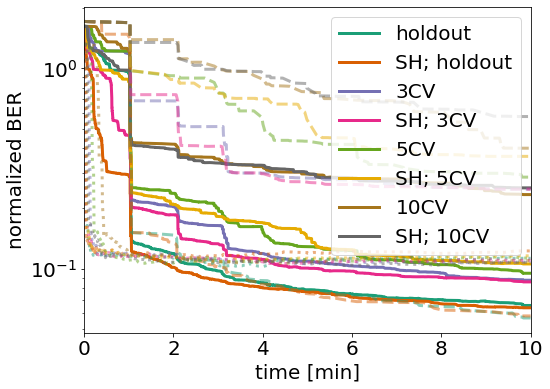

In [5]:
# Plot average BER across all datasets
HORIZON = 10
model_list = []
for m in valid_pretty[HORIZON].keys():
    model_list.append(m)
average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
             horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
             min_diff_dc=min_diff_dc)
plt.yscale("log")
plt.show()

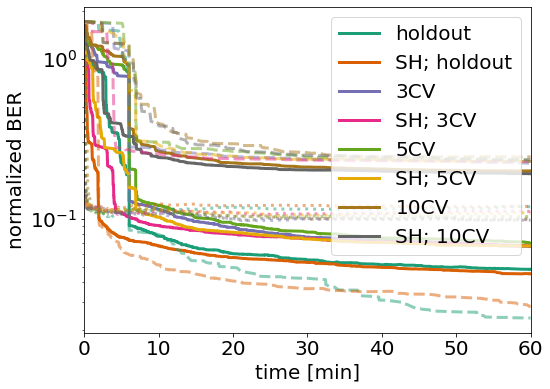

In [6]:
# Plot average BER across all datasets
HORIZON = 60
model_list = []
for m in valid_pretty[HORIZON].keys():
    model_list.append(m)
average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
             horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
             min_diff_dc=min_diff_dc)
plt.yscale("log")
plt.show()

189872


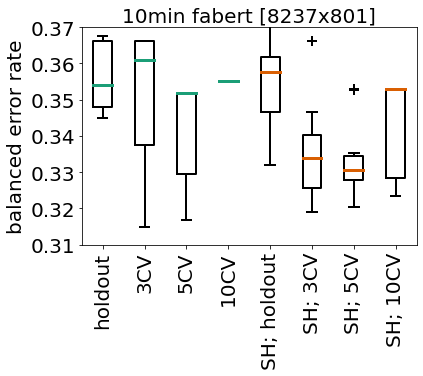

126026


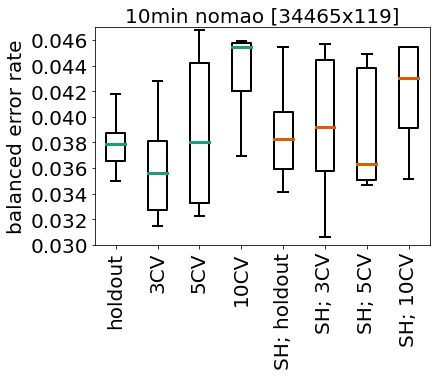

168798


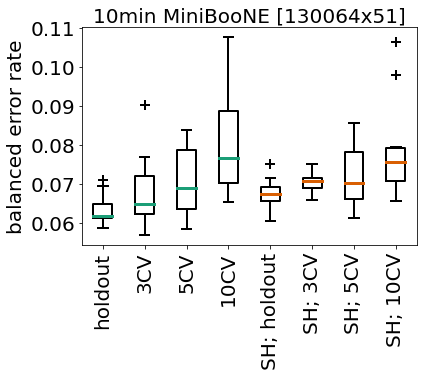

189872


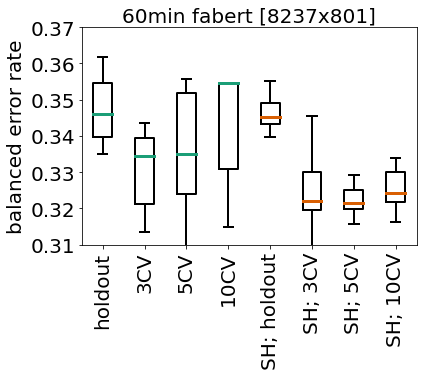

126026


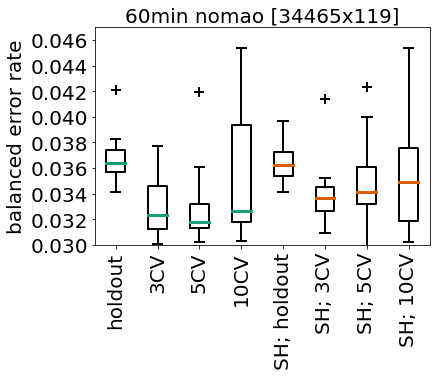

168798


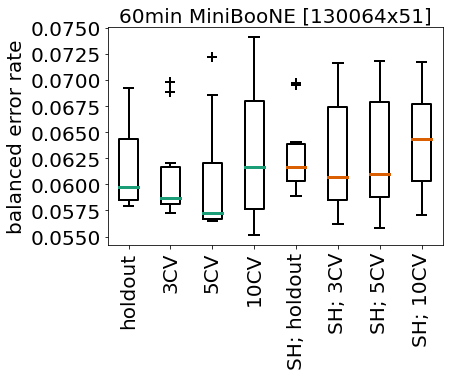

In [7]:
# Box plots
lims = {
    "robert": [0.53, 0.64],
    "fabert": [0.31, 0.37],
    "nomao": [0.03, 0.047],
}

for horizon in res_dc:
    model_list = sorted(list(valid_pretty[horizon].keys()), key=lambda x: "SH" in x[1])
    for tid in [189872, 126026, 168798]:
    #for tid in task_ids_sorted_by_num_features:
        print(tid)
        losses = {}
        for m in model_list:
            data = res_dc[horizon][tid][m]
            assert len(data) == n_seeds
            final_losses = []
            for traj in data:
                keys = np.sort(list(traj.keys()))
                l = traj[keys[-1]]
                final_losses.append(l)
            losses[m] = np.array(final_losses)
        labels = [valid_pretty[horizon][m] for m in model_list]
        plt.boxplot(
            [losses[m] for m in model_list[:4]],
            positions=np.arange(4),
            labels=labels[:4],
            boxprops={"linewidth": 2},
            whiskerprops={"linewidth": 2},
            capprops={"linewidth": 2},
            medianprops={"linewidth": 3, "c": style_dc["colors"][0]},
            flierprops={"marker": "+", "markersize": 10, "markeredgewidth": 2}
                   )
        plt.boxplot(
            [losses[m] for m in model_list[4:]],
            positions=np.arange(4, 8),
            labels=labels[4:],
            boxprops={"linewidth": 2},
            whiskerprops={"linewidth": 2},
            capprops={"linewidth": 2},
            medianprops={"linewidth": 3, "c": style_dc["colors"][1]},
            flierprops={"marker": "+", "markersize": 10, "markeredgewidth": 2}
                   )
        plt.xticks(rotation=90, fontsize=style_dc["fontsize"])
        plt.yticks(fontsize=style_dc["fontsize"])
        plt.ylabel("balanced error rate", fontsize=style_dc["fontsize"])
        title = "%dmin %s [%dx%d]"
        plt.title(title % (horizon, tasks.loc[tid, 'name'], tasks.loc[tid, 'NumberOfInstances'], 
                           tasks.loc[tid, 'NumberOfFeatures']),
                 fontsize=style_dc["fontsize"])
        if tasks.loc[tid, 'name'] in lims:
            plt.ylim(lims[tasks.loc[tid, 'name']])
        plt.show()

In [8]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        model_list[h].append(m)

tab_data, stat_test_data = collect_data_for_final_table(model_list, res_dc, valid_pretty, horizon_list,
                                                        task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, exclude=["oracle",])

Not different with 10 mins:
	 SH; holdout vs holdout: 0.477743
	SH; holdout vs 3CV: 0.667349
	SH; holdout vs SH; 3CV: 0.852364
	SH; holdout vs 5CV: 0.269601
	SH; holdout vs SH; 5CV: 0.174898
Not different with 60 mins:
	 SH; holdout vs holdout: 0.297955
	SH; holdout vs 3CV: 0.99011
	SH; holdout vs SH; 3CV: 0.950189
	SH; holdout vs 5CV: 0.890284
	SH; holdout vs SH; 5CV: 0.890284
	SH; holdout vs 10CV: 0.283609
	SH; holdout vs SH; 10CV: 0.702045


In [9]:
df = pd.DataFrame(tab_data)
#for horizon in horizon_list:
#    df['Rank_%s' % horizon] = df[horizon].rank(method='average', ascending=True)
print(df.to_latex())
print(not_different)

\begin{tabular}{lrrrr}
\toprule
{} &     10 &  STD 10 &     60 &  STD 60 \\
\midrule
holdout     &   6.55 &    0.62 &   4.83 &    0.47 \\
SH; holdout &   6.38 &    0.54 &   4.52 &    0.29 \\
3CV         &   8.75 &    0.45 &   6.69 &    0.33 \\
SH; 3CV     &   8.59 &    0.62 &   6.76 &    0.38 \\
5CV         &   9.48 &    0.74 &   7.02 &    0.52 \\
SH; 5CV     &  10.56 &    1.59 &   6.74 &    0.45 \\
10CV        &  23.41 &    1.22 &  19.86 &    0.53 \\
SH; 10CV    &  25.29 &    3.03 &  19.09 &    0.49 \\
\bottomrule
\end{tabular}

{10: [('SH; holdout', 'holdout', 0.4777426043606792), ('SH; holdout', '3CV', 0.6673490983569998), ('SH; holdout', 'SH; 3CV', 0.8523636805158508), ('SH; holdout', '5CV', 0.26960108581203124), ('SH; holdout', 'SH; 5CV', 0.1748980508284848)], 60: [('SH; holdout', 'holdout', 0.2979554669042891), ('SH; holdout', '3CV', 0.9901097248691251), ('SH; holdout', 'SH; 3CV', 0.950189084390776), ('SH; holdout', '5CV', 0.8902839892891921), ('SH; holdout', 'SH; 5CV', 0.8902839

Plotting 8 models
0 / 200
50 / 200
100 / 200
150 / 200


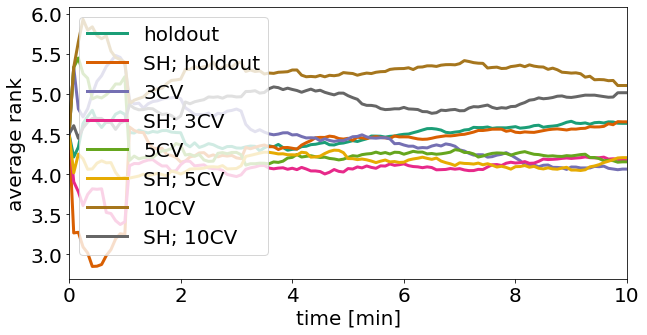

In [10]:
HORIZON = 10
model_list = []
for m in valid_pretty[HORIZON].keys():
    if "oracle" in m[1]:
        continue
    model_list.append(m)
rank(model_list, res_dc, valid_pretty, HORIZON, task_ids_sorted_by_num_features, n_iter=200, steplength=5)